## Tensorflow

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()

2023-10-26 16:06:44.899838: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


False

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{2}"

In [3]:
# A function to compute the value of latent space using mu and sigma
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps
# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
# KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)
# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False, sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

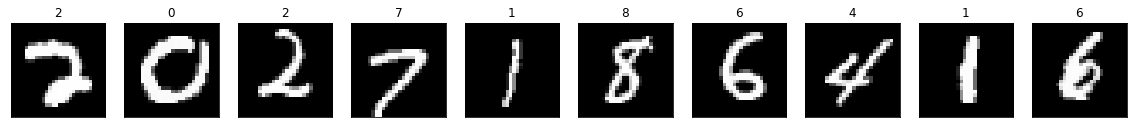

In [4]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Displaying data
fig, axes = plt.subplots(ncols=10, sharex=False, sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [5]:
# Normalize values such that all numbers are within
# the range of 0 to 1
X_train = X_train/255
X_test = X_test/255
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

In [6]:
# Constructing encoder
encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)
#latent space
mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)
#Decoder
# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, padding='same', activation='sigmoid')(decoder_conv)

In [7]:
# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [8]:
# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=30, batch_size=32, validation_data=(X_test_new,X_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


2023-10-26 16:08:36.627602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 16:08:38.936001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6292 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5
2023-10-26 16:08:38.971857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-10-26 16:08:45.358556: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202


60000/60000 [==============================] - ETA: 0s - loss: 192.5905

/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 43s 712us/sample - loss: 192.5905 - val_loss: 175.4159
Epoch 2/30
60000/60000 [==============================] - 20s 337us/sample - loss: 173.7947 - val_loss: 172.7581
Epoch 3/30
60000/60000 [==============================] - 20s 336us/sample - loss: 171.6660 - val_loss: 170.5096
Epoch 4/30
60000/60000 [==============================] - 20s 334us/sample - loss: 169.3463 - val_loss: 168.3386
Epoch 5/30
60000/60000 [==============================] - 20s 339us/sample - loss: 167.8125 - val_loss: 167.3967
Epoch 6/30
60000/60000 [==============================] - 20s 340us/sample - loss: 166.8750 - val_loss: 166.4258
Epoch 7/30
60000/60000 [==============================] - 21s 342us/sample - loss: 166.3099 - val_loss: 166.1570
Epoch 8/30
60000/60000 [==============================] - 20s 337us/sample - loss: 165.8770 - val_loss: 165.5028
Epoch 9/30
60000/60000 [==============================] - 20s 341us/sample - loss: 165.5117 - val_loss: 165

## Pytorch - Flow

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{4}"

In [3]:
# # create a transofrm to apply to each datapoint
# transform = transforms.Compose([transforms.ToTensor()])

# # download the MNIST datasets
# path = '~/datasets'
# train_dataset = MNIST(path, transform=transform, download=True)
# test_dataset  = MNIST(path, transform=transform, download=True)

# # create train and test dataloaders
# batch_size = 1
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(3, 960, 960)


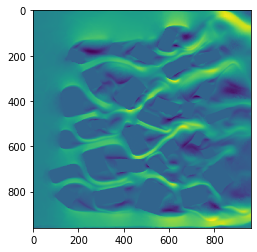

In [4]:
data = np.load('/home/dg321/gitTest/PRI/irp/tests_for_donghu1/buildings_960_960_Velocity.npy')

size_start_train = 0
size_end_train = 960

data = np.stack([np.rot90(data[size_start_train:size_end_train,size_start_train:size_end_train], 1)] * 3, axis=0)

print(data.shape)
plt.imshow(data[0,:,:], interpolation='none')
plt.show()

In [5]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample
    

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 1

# Create the dataset and dataloader
dataset = CustomImageDataset(transform=transform)
dataloader = DataLoader(dataset)  # Adjust batch size as needed

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

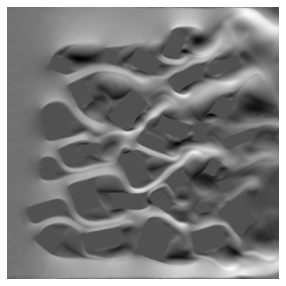

In [6]:
# get 25 sample dataing images for visualization
dataiter = iter(dataloader)
image = dataiter.next()

num_samples = 1
# print(image[0][2,0].shape)
x_dim = 960*960
sample_images = [image[0]] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im[0], cmap='gray')
    ax.axis('off')

plt.show()

In [3]:
class VAE(nn.Module):

    def __init__(self, input_dim=960*960, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)     
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [69]:
# Conv2D
# class VAE(nn.Module):
#     # def __init__(self, input_dim=960*960, hidden_dim=400, latent_dim=200):
#     def __init__(self, latent_dim=100):
#         super(VAE, self).__init__()

#         # # encoder
#         # self.encoder = nn.Sequential(
#         #     nn.Linear(input_dim, hidden_dim),
#         #     nn.LeakyReLU(0.2),
#         #     nn.Linear(hidden_dim, latent_dim),
#         #     nn.LeakyReLU(0.2)
#         #     )

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=2, stride=2, padding=0),  # Layer 1
#             nn.ReLU(True),
#             nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0),  # Layer 2
#             nn.ReLU(True),
#             nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0),  # Layer 3
#             nn.ReLU(True),
#             nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0),  # Layer 4
#             nn.ReLU(True),
#             nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0),  # Layer 5
#             nn.ReLU(True),
#             nn.Linear(30, latent_dim),
#             nn.LeakyReLU(0.2),
#         )
        
#         # latent mean and variance 
#         self.mean_layer = nn.Linear(latent_dim, 2)
#         self.logvar_layer = nn.Linear(latent_dim, 2)
        
#         # # decoder
#         # self.decoder = nn.Sequential(
#         #     nn.Linear(2, latent_dim),
#         #     nn.LeakyReLU(0.2),
#         #     nn.Linear(latent_dim, hidden_dim),
#         #     nn.LeakyReLU(0.2),
#         #     nn.Linear(hidden_dim, input_dim),
#         #     nn.Sigmoid()
#         #     )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(2, latent_dim),
#             nn.LeakyReLU(0.2),
#             nn.Linear(latent_dim, 30),
#             nn.LeakyReLU(0.2),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),  # Layer 1
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),  # Layer 2
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),  # Layer 3
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),  # Layer 4
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=0),  # Layer 5
#             nn.Sigmoid()
#         )
        
#     def encode(self, x):
#         x = self.encoder(x)
#         mean, logvar = self.mean_layer(x), self.logvar_layer(x)
#         return mean, logvar

#     def reparameterization(self, mean, var):
#         epsilon = torch.randn_like(var)    
#         z = mean + var*epsilon
#         return z
    
#     def decode(self, x):
#         return self.decoder(x)

#     def forward(self, x):
#         mean, logvar = self.encode(x)
#         z = self.reparameterization(mean, logvar)
#         x_hat = self.decode(z)
#         return x_hat, mean, log_var
        
#     def forward(self, x):
#         mean, log_var = self.encode(x)
#         z = self.reparameterization(mean, torch.exp(0.5 * log_var))
#         print(z.shape) 
#         x_hat = self.decode(z)  
#         return x_hat, mean, log_var

In [5]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=3*1e-3)

In [33]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [34]:
def train(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x) in enumerate(dataloader):
            x = x.view(batch_size, x_dim)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_size))
    return overall_loss

train(model, optimizer, epochs=100)

	Epoch 1 	Average Loss:  7320493.5
	Epoch 2 	Average Loss:  1288461329.25
	Epoch 3 	Average Loss:  4.3222891055982034e+29
	Epoch 4 	Average Loss:  1.2966405658247245e+30
	Epoch 5 	Average Loss:  1.2966669355191648e+30
	Epoch 6 	Average Loss:  1.2966603619850207e+30
	Epoch 7 	Average Loss:  1.2965416228021754e+30
	Epoch 8 	Average Loss:  1.2965614189624716e+30
	Epoch 9 	Average Loss:  1.296680120366385e+30
	Epoch 10 	Average Loss:  1.296686731679461e+30
	Epoch 11 	Average Loss:  1.2965680680544795e+30
	Epoch 12 	Average Loss:  1.2966933052136052e+30
	Epoch 13 	Average Loss:  1.2967526936944937e+30
	Epoch 14 	Average Loss:  1.2967593050075698e+30
	Epoch 15 	Average Loss:  1.2967262862211215e+30
	Epoch 16 	Average Loss:  1.296686731679461e+30
	Epoch 17 	Average Loss:  1.296686731679461e+30
	Epoch 18 	Average Loss:  1.296686731679461e+30
	Epoch 19 	Average Loss:  1.296686731679461e+30
	Epoch 20 	Average Loss:  1.296686731679461e+30
	Epoch 21 	Average Loss:  1.296686731679461e+30
	Epoch 22 

1.2967262862211215e+30

In [39]:
torch.save(model.state_dict(), './models/vae_model_960_{}epochs.pth'.format(100))

In [6]:
model.load_state_dict(torch.load('./models/vae_model_960_{}epochs.pth'.format(100)))

<All keys matched successfully>

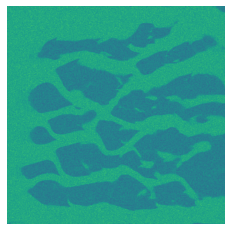

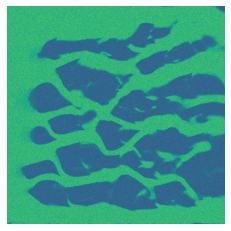

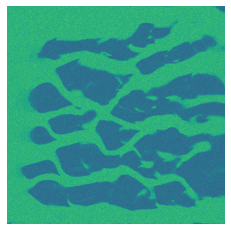

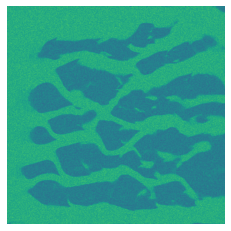

(None, None, None, None)

In [8]:


def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)

    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().numpy().reshape(960, 960) # reshape vector to 2d array
    plt.imshow(digit)
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0), generate_digit(0.5, 0.5),generate_digit(0.5, 1.0)

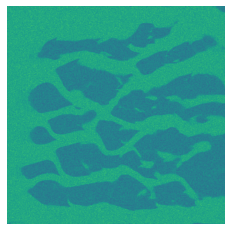

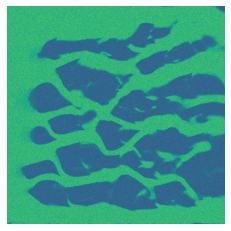

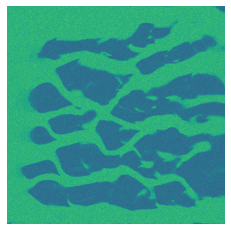

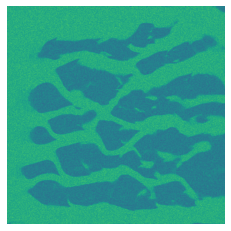

(None, None, None, None)

In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)

    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().numpy().reshape(data.shape[-1], data.shape[-1]) # reshape vector to 2d array
    plt.imshow(digit)
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0), generate_digit(0.5, 0.5),generate_digit(0.5, 1.0)

## Pytorch - Buildings

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{1}"

In [3]:
# # create a transofrm to apply to each datapoint
# transform = transforms.Compose([transforms.ToTensor()])

# # download the MNIST datasets
# path = '~/datasets'
# train_dataset = MNIST(path, transform=transform, download=True)
# test_dataset  = MNIST(path, transform=transform, download=True)

# # create train and test dataloaders
# batch_size = 1
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(3, 800, 400)


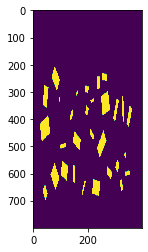

In [30]:
data = np.load('/home/dg321/gitTest/PRI/irp/fortran_building_volume_frac_codes/vol_frac_plot.npy')

size_start_train = 0
size_end_train = data.shape[-1]

data = np.stack([np.rot90(data[size_start_train:size_end_train,size_start_train:size_end_train], 1)] * 3, axis=0)

print(data.shape)
plt.imshow(data[0,:,:], interpolation='none')
plt.show()

In [31]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample
    

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 1

# Create the dataset and dataloader
dataset = CustomImageDataset(transform=transform)
dataloader = DataLoader(dataset)  # Adjust batch size as needed

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

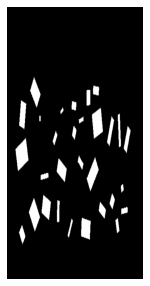

In [32]:
# get 25 sample dataing images for visualization
dataiter = iter(dataloader)
image = dataiter.next()

num_samples = 1
# print(image[0][2,0].shape)
x_dim = data.shape[-1]*data.shape[-2]
sample_images = [image[0]] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im[0], cmap='gray')
    ax.axis('off')

plt.show()

In [33]:
class VAE(nn.Module):

    def __init__(self, input_dim=data.shape[-1]*data.shape[-2], hidden_dim=400, latent_dim=200, latentspace_scale=10):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2*latentspace_scale)
        self.logvar_layer = nn.Linear(latent_dim, 2*latentspace_scale)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2*latentspace_scale, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)     
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [34]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=3*1e-3)

In [35]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [36]:
def train(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x) in enumerate(dataloader):
            x = x.view(batch_size, x_dim)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_size))
    return overall_loss

epochs = 20
train(model, optimizer, epochs=epochs)

	Epoch 1 	Average Loss:  6.064640144976921e+20
	Epoch 2 	Average Loss:  5.470802658061582e+18
	Epoch 3 	Average Loss:  16652726031.391113
	Epoch 4 	Average Loss:  28684326769.930664
	Epoch 5 	Average Loss:  11447.0859375
	Epoch 6 	Average Loss:  9010.909912109375
	Epoch 7 	Average Loss:  305180.3515625
	Epoch 8 	Average Loss:  240149.82421875
	Epoch 9 	Average Loss:  482314.375
	Epoch 10 	Average Loss:  622817.75
	Epoch 11 	Average Loss:  649647.203125
	Epoch 12 	Average Loss:  594117.125
	Epoch 13 	Average Loss:  497655.78125
	Epoch 14 	Average Loss:  391197.6328125
	Epoch 15 	Average Loss:  285317.1328125
	Epoch 16 	Average Loss:  197995.3203125
	Epoch 17 	Average Loss:  142366.19921875
	Epoch 18 	Average Loss:  111576.97265625
	Epoch 19 	Average Loss:  92520.373046875
	Epoch 20 	Average Loss:  77764.080078125


77764.080078125

In [ ]:
torch.save(model.state_dict(), './models/VAE_Building_0_960_{}epochs.pth'.format(epochs))  ### Prediction

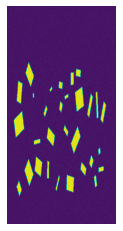

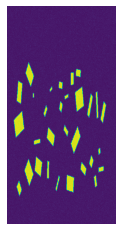

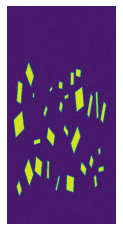

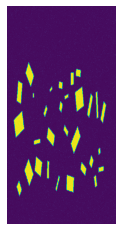

(None, None, None, None)

In [41]:
latentspace_scale = 10

def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]]*latentspace_scale, dtype=torch.float).view(20)

    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().numpy().reshape(data.shape[-2], data.shape[-1]) # reshape vector to 2d array
    plt.imshow(digit)
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0), generate_digit(0.5, 0.5),generate_digit(0.5, 1.0)